In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import json
import os
from shutil import move, copy

from ultralytics import YOLO

# Setting up the Data

In [2]:
data = pd.read_csv('../data/interim/annots_imgs_merged.csv')
scatterplots = data[data['chart-type'] == 'scatter']
scatterplots = scatterplots.head(4000)
scatterplots = scatterplots[['data-series','visual-elements.scatter points','file_name','image_path']]
scatterplots.columns = ['data_series','data_coords','name','path']
scatterplots.reset_index(drop=True, inplace=True)
scatterplots.head()

,data_series,data_coords,name,path
0,"[{'x': 1949.4200576738224, 'y': 66.68303958393...","[[{'x': 89.33333333333334, 'y': 75.59999999999...",e91e28111e86,../data/interim/Scatterplots/e91e28111e86.jpg
1,"[{'x': 0.9445463278316278, 'y': 52.13870797394...","[[{'x': 68.76190476190474, 'y': 188.2023809523...",66dd2a250237,../data/interim/Scatterplots/66dd2a250237.jpg
2,"[{'x': 0.8933632249058832, 'y': 5.440194292653...","[[{'x': 93.33333333333333, 'y': 210.9666666666...",497a547454d7,../data/interim/Scatterplots/497a547454d7.jpg
3,"[{'x': 0.9873584566532869, 'y': 30.64333251170...","[[{'x': 67.83333333333334, 'y': 167.15}, {'x':...",07fb50377c3c,../data/interim/Scatterplots/07fb50377c3c.jpg
4,"[{'x': 1989.854169237731, 'y': 31.103360811667...","[[{'x': 105.83333333333334, 'y': 212.799999999...",daa43320159b,../data/interim/Scatterplots/daa43320159b.jpg


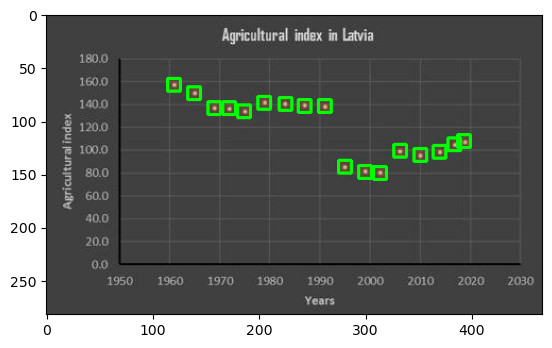

In [10]:
coords = scatterplots['data_coords'][15]
coords = coords.replace("'", "\"")
coords_list = json.loads(coords)

    # extract important image info
path = scatterplots['path'][15]
name = scatterplots['name'][15]
img = cv2.imread(path)
height = img.shape[0]
width = img.shape[1]

    # Save the xy coords into a list
xy_coords = []
for data_point in coords_list[0]:
    xy_coords.append((data_point['x']-6,
                      data_point['y']-6,
                      data_point['x']+6,
                      data_point['y']+6))
    
scatter_img = img.copy()
for bbox in xy_coords:
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            cv2.rectangle(scatter_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(scatter_img)
plt.show()

In [11]:
dataframes = []
for i in range(len(scatterplots)):
    # extract xy coordinates from data_coords column
    coords = scatterplots['data_coords'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = scatterplots['path'][i]
    name = scatterplots['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    xy_coords = []
    for data_point in coords_list[0]:
        xy_coords.append((data_point['x'],data_point['y']))

    # Transform the xy coords into YOLO bboxes 
    bboxes = []
    for xy in xy_coords:
        x, y = xy
        bbox = (int(x)/width, int(y)/height, 12/width, 12/height)
        bboxes.append(bbox)

    # Save into list of dataframe
    yolo = pd.DataFrame(bboxes, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)
yolo_df['path'].nunique()
    


4000

In [12]:
yolo_df.head()

,path,name,class,x,y,w,h
0,../data/interim/Scatterplots/e91e28111e86.jpg,e91e28111e86,0,0.176938,0.218659,0.023857,0.034985
1,../data/interim/Scatterplots/e91e28111e86.jpg,e91e28111e86,0,0.212724,0.221574,0.023857,0.034985
2,../data/interim/Scatterplots/e91e28111e86.jpg,e91e28111e86,0,0.250497,0.227405,0.023857,0.034985
3,../data/interim/Scatterplots/e91e28111e86.jpg,e91e28111e86,0,0.282306,0.244898,0.023857,0.034985
4,../data/interim/Scatterplots/e91e28111e86.jpg,e91e28111e86,0,0.314115,0.268222,0.023857,0.034985


# Train/Test Split

In [13]:
unique_images = yolo_df['path'].unique()
img_df = pd.DataFrame(unique_images,columns=['path'])
img_train = tuple(img_df.sample(frac=0.8)['path'])
img_test = tuple(img_df.query(f'path not in {img_train}')['path'])
len(img_train), len(img_test)

(3200, 800)

In [14]:
train_df = yolo_df.query(f'path in {img_train}')
test_df = yolo_df.query(f'path in {img_test}')

In [15]:
train_df

,path,name,class,x,y,w,h
0,../data/interim/Scatterplots/66dd2a250237.jpg,66dd2a250237,0,0.143763,0.696296,0.025370,0.044444
1,../data/interim/Scatterplots/66dd2a250237.jpg,66dd2a250237,0,0.179704,0.588889,0.025370,0.044444
2,../data/interim/Scatterplots/66dd2a250237.jpg,66dd2a250237,0,0.211416,0.548148,0.025370,0.044444
3,../data/interim/Scatterplots/66dd2a250237.jpg,66dd2a250237,0,0.245243,0.737037,0.025370,0.044444
4,../data/interim/Scatterplots/66dd2a250237.jpg,66dd2a250237,0,0.276956,0.222222,0.025370,0.044444
...,...,...,...,...,...,...,...
10,../data/interim/Scatterplots/955b37b5a4ef.jpg,955b37b5a4ef,0,0.711968,0.670068,0.024341,0.040816
11,../data/interim/Scatterplots/955b37b5a4ef.jpg,955b37b5a4ef,0,0.760649,0.721088,0.024341,0.040816
12,../data/interim/Scatterplots/955b37b5a4ef.jpg,955b37b5a4ef,0,0.809331,0.724490,0.024341,0.040816
13,../data/interim/Scatterplots/955b37b5a4ef.jpg,955b37b5a4ef,0,0.855984,0.721088,0.024341,0.040816


In [16]:
src_folder = '../data/interim/Scatterplots/'
train_folder = '../data/YOLO/Scatterplots/train/'
test_folder = '../data/YOLO/Scatterplots/test/'

In [18]:
cols = ['name','class','x','y','w','h']
groupby_obj_train = train_df[cols].groupby('name')
groupby_obj_test = test_df[cols].groupby('name')

In [19]:
def save_data(filename, folder_path, group_obj):
    #copy image
    src = os.path.join(src_folder,filename)+'.jpg'
    dst = os.path.join(folder_path, filename)+'.jpg'
    copy(src, dst)

    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [20]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series.apply(save_data,args=(train_folder, groupby_obj_train))

0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [21]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data,args=(test_folder, groupby_obj_test))


0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

# Training the Model

In [22]:
# model = YOLO('yolov8s-p2.yaml').load('yolov8s.pt')
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

In [ ]:
# results = model.train(data='../data/YOLO/Scatterplots/data.yaml', epochs=10)

Ultralytics YOLOv8.0.136 🚀 Python-3.11.3 torch-2.0.1 CPU (Intel Core(TM) i5-8210Y 1.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=../data/YOLO/Scatterplots/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False

ClearML Task: created new task id=6761adfcdcd642438b17a806acf81d20
ClearML results page: https://app.clear.ml/projects/1722549c7c244bde9749c7a037d96012/experiments/6761adfcdcd642438b17a806acf81d20/output/log


ClearML Initialized a new task. If you want to run remotely, please add clearml-init and connect your arguments before initializing YOLO.
TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
train: Scanning /Users/matt/Desktop/graphs-capstone/data/YOLO/Scatterplots/train... 472 images, 0 backgrounds, 0 corrupt:  15%|█▍        | 472/3200 [00:00<00:03, 729.15it/s]

ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


train: Scanning /Users/matt/Desktop/graphs-capstone/data/YOLO/Scatterplots/train... 3200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3200/3200 [00:05<00:00, 585.26it/s]
train: New cache created: /Users/matt/Desktop/graphs-capstone/data/YOLO/Scatterplots/train.cache
val: Scanning /Users/matt/Desktop/graphs-capstone/data/YOLO/Scatterplots/test... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:01<00:00, 494.36it/s]
val: New cache created: /Users/matt/Desktop/graphs-capstone/data/YOLO/Scatterplots/test.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
  0%|          | 0/200 [00:00<?, ?it/s]

2023-07-17 19:46:03,918 - clearml.Task - INFO - Storing jupyter notebook directly as code


        1/5         0G       2.15      126.7      1.326        654        640:   2%|▎         | 5/200 [02:52<1:44:54, 32.28s/it]

        1/5         0G       2.15      126.7      1.326        654        640:   2%|▎         | 5/200 [03:47<2:27:53, 45.50s/it]
